#  Develop a Caption Generation Model
Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a photograph.

It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order. Recently, deep learning methods have achieved state of the art results on examples of this problem.

It can be hard to develop caption generating models on your own data, primarily because the datasets and the models are so large and take days to train. An alternative approach is to explore model configurations with a small sample of the fuller dataset.

![pic](https://imgur.com/JcN1RM4.png)

The Caption Generation Model has 6 parts, they are:

1. Data Preparation
2. Baseline Caption Generation Model
3. Network Size Parameters
4. Configuring the Feature Extraction Model
5. Word Embedding Models
6. Analysis of Results

# Data Preparation

We will use the Flickr8K dataset that is comprised of a little more than 8,000 photographs and their descriptions.

You can download the dataset from here:

[Framing image description as a ranking task: data, models and evaluation metrics.](http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/KCCA.html)

Unzip the photographs and descriptions into your current working directory into Flicker8k_Dataset and Flickr8k_text directories respectively.

There are two parts to the data preparation, they are:

* Preparing the Text
* Preparing the Photos

## Preparing the Text

The dataset contains multiple descriptions for each photograph and the text of the descriptions requires some minimal cleaning.

First, we will load the file containing all of the descriptions.

In [1]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
filename = 'D:/Program/dataset/Flickr8K/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

Each photo has a unique identifier. This is used in the photo filename and in the text file of descriptions. Next, we will step through the list of photo descriptions and save the first description for each photo. Below defines a function named `load_descriptions()` that, given the loaded document text, will return a dictionary of photo identifiers to descriptions.

In [2]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # store the first description for each image
        if image_id not in mapping:
            mapping[image_id] = image_desc
    return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: {} '.format(len(descriptions)))

Loaded: 8092 


---
Next, we need to clean the description text.

The descriptions are already tokenized and easy to work with. We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

* Convert all words to lowercase.
* Remove all punctuation.
* Remove all words that are one character or less in length (e.g. ‘a’).

Below defines the `clean_descriptions()` function that, given the dictionary of image identifiers to descriptions, steps through each description and cleans the text.

In [3]:
import string

def clean_descriptions(descriptions):
    """
    This uses the 3-argument version of str.maketrans
    with arguments (x, y, z) where 'x' and 'y'
    must be equal-length strings and characters in 'x'
    are replaced by characters in 'y'. 'z'
    is a string (string.punctuation here)
    where each character in the string is mapped
    to None.
    
    This is an alternative that creates a dictionary mapping
    of every character from string.punctuation to None (this will
    also work)
    #translator = str.maketrans(dict.fromkeys(string.punctuation))
    """
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc in descriptions.items():
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # store as string
        descriptions[key] =  ' '.join(desc)

        
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: {}'.format(len(vocabulary)))

Vocabulary Size: 4484


---
Finally, we save the dictionary of image identifiers and descriptions to a new file named *descriptions.txt*, with one image identifier and description per line.

Below defines the `save_doc()` function that given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file.

In [4]:
# save descriptions to file, one per line
def save_doc(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
# save descriptions
save_doc(descriptions, 'D:/Program/dataset/Flickr8K/descriptions.txt')

## Preparing the Photos

We will use a pre-trained model to interpret the content of the photos.

There are many models to choose from. In this case, we will use the Oxford Visual Geometry Group or VGG model that won the ImageNet competition in 2014.Keras provides this pre-trained model directly.

We could use this model as part of a broader image caption model. The problem is, it is a large model and running each photo through the network every time we want to test a new language model configuration (downstream) is redundant.

Instead, we can pre-compute the “photo features” using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset. It is no different to running the photo through the full VGG model, it is just that we will have done it once in advance.

This is an optimization that will make training our models faster and consume less memory.

We can load the VGG model in Keras using the VGG class. We will load the model without the top; this means without the layers at the end of the network that are used to interpret the features extracted from the input and turn them into a class prediction. We are not interested in the image net classification of the photos and we will train our own interpretation of the image features.

Below is a function named extract_features() that given a directory name will load each photo, prepare it for VGG and collect the predicted features from the VGG model. The image features are a 3-dimensional array with the shape (7, 7, 512).

The function returns a dictionary of image identifier to image features.
We can call this function to prepare the photo data for testing our models, then save the resulting dictionary to a file named *features.pkl*.

In [5]:
%%time
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer)
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        
        if len(features)%100==0:
            print('>{}'.format(name))
    return features

# extract features from all images
directory = 'D:/Program/dataset/Flickr8K/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: {}'.format(len(features)))
# save to file
dump(features, open('D:/Program/dataset/Flickr8K/features.pkl', 'wb'))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

---
Running this data preparation step may take a while depending on your hardware, perhaps one hour on the CPU with a modern workstation.

At the end of the run, you will have the extracted features stored in *features.pkl* for later use.

# Baseline Caption Generation Model

In this section, we will define a baseline model for generating captions for photos and how to evaluate it so that it can be compared to variations on this baseline.

This section is divided into 6 parts:

1. Load Data.
2. Fit Model.
3. Evaluate Model.
4. Complete Example
5. “A” versus “A” Test
6. Generate Photo Captions

## Load Data

We are not going to fit the model on all of the caption data, or even on a large sample of the data.

In this tutorial, we are interested in quickly testing a suite of different configurations of a caption model to see what works on this data. That means we need the evaluation of one model configuration to happen quickly. Toward this end, we will train the models on 100 photographs and captions, then evaluate them on both the training dataset and on a new test set of 100 photographs and captions.

First, we need to load a pre-defined subset of photographs. The provided dataset has separate sets for train, test, and development, which are really just different groups of photo identifiers. We will load the development set and use the first 100 identifiers for train and the second 100 (e.g. from 100 to 200) as the test set.

The function `load_set()` below will load a pre-defined set of identifiers, and we will call it with the *Flickr_8k.devImages.txt* filename as an argument.

In [20]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

Next, we need to split the set into train and test sets.

We will start by ordering the identifiers by sorting them to ensure we always split them consistently across machines and runs, then take the first 100 for train and the next 100 for test.

The `train_test_split()` function below will create this split given the loaded set of identifiers as input.

In [25]:
# split a dataset into train/test elements
def train_test_split(dataset):
    # order keys so the split is consistent
    ordered = sorted(dataset)
    # return split dataset as two new sets
    return set(ordered[:100]), set(ordered[100:200])

Now, we can load the photo descriptions using the pre-defined set of train or test identifiers.

Below is the function `load_clean_descriptions()` that loads the cleaned text descriptions from *descriptions.txt* for a given set of identifiers and returns a dictionary of identifier to text.

The model we will develop will generate a caption given a photo, and the caption will be generated one word at a time. The sequence of previously generated words will be provided as input. Therefore, we will need a ***first word*** to kick-off the generation process and a ***last word*** to signal the end of the caption. We will use the strings ***startseq*** and ***endseq*** for this purpose.

In [9]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # store
            descriptions[image_id] = 'startseq ' + ' '.join(image_desc) + ' endseq'
    return descriptions

Next, we can load the photo features for a given dataset.

Below defines a function named `load_photo_features()` that loads the entire set of photo descriptions, then returns the subset of interest for a given set of photo identifiers. This is not very efficient as the loaded dictionary of all photo features is about 700 Megabytes. Nevertheless, this will get us up and running quickly.


In [12]:
from pickle import load

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [27]:
# load dev set
filename = 'D:/Program/dataset/Flickr8K/Flickr8k_text/Flickr_8k.devImages.txt'
dataset = load_set(filename)
print('Dataset: {}'.format(len(dataset)))
# train-test split
train, test = train_test_split(dataset)
print('Train={}, Test={}'.format(len(train), len(test)))
# descriptions
train_descriptions = load_clean_descriptions('D:/Program/dataset/Flickr8K/descriptions.txt', train)
test_descriptions = load_clean_descriptions('D:/Program/dataset/Flickr8K/descriptions.txt', test)
print('Descriptions: train={}, test={}'.format(len(train_descriptions), len(test_descriptions)))
# photo features
train_features = load_photo_features('D:/Program/dataset/Flickr8K/features.pkl', train)
test_features = load_photo_features('D:/Program/dataset/Flickr8K/features.pkl', test)
print('Photos: train={}, test={}'.format(len(train_features), len(test_features)))

Dataset: 1000
Train=100, Test=100
Descriptions: train=100, test=100
Photos: train=100, test=100


---
Running this example first loads the 1,000 photo identifiers in the development dataset. A train and test set is selected and used to filter the set of clean photo descriptions and prepared image features.

The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the Tokenizer class that can learn this mapping from the loaded description data.

Below defines the `create_tokenizer()` that will fit a Tokenizer given the loaded photo description text.

In [47]:
import numpy as np
import pandas as pd

from nltk.translate.bleu_score import corpus_bleu
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D
from IPython.display import Image

In [42]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(vocab_size))

# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: {}'.format(max_length))

Vocabulary Size: 4485
Description Length: 25


---
Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained.

For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:

| X1 | X2 (text sequence) | y (word) |
| --- | --- | --- |
| photo | startseq, | little |
| photo | startseq, little, | girl |
| photo | startseq, little, girl, | running |
| photo | startseq, little, girl, running, | in |
| photo | startseq, little, girl, running, in, | field |
| photo | startseq, little, girl, running, in, field, | endseq |

Later when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

The function below named `create_sequences()` given the tokenizer, a single clean description, the features for a photo, and the maximum description length will prepare a set of input-output pairs for training a model. Calling this function will return *X1* and *X2* for the arrays of image data and input sequence data and the *y* value for the output word.

The input sequences are integer encoded and the output word is one-hot encoded to represent the probability distribution of the expected word across the whole vocabulary of possible words.

In [43]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the description
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        Ximages.append(image)
        XSeq.append(in_seq)
        y.append(out_seq)
    # Ximages, XSeq, y = array(Ximages), array(XSeq), array(y)
    return [Ximages, XSeq, y]

## Fit Model

The model is based on the example laid out in the paper [“Show and Tell: A Neural Image Caption Generator“](https://arxiv.org/abs/1411.4555), 2015.

The model involves three parts:

* **Photo Feature Extractor**. This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with a the VGG model (without the top) and will use the extracted features predicted by this model as input.
* **Sequence Processor**. This is a word embedding layer for handling the text input, followed by an LSTM layer. The LSTM output is interpreted by a Dense layer one output at a time.
* **Interpreter (for lack of a better name)**. Both the feature extractor and sequence processor output a fixed-length vector that is the length of a maximum sequence. These are concatenated together and processed by an LSTM and Dense layer before a final prediction is made.

A conservative number of neurons is used in the base model. Specifically, a 128 Dense layer after the feature extractor, a 50-dimensionality word embedding followed by a 256 unit LSTM and 128 neuron Dense after the sequence processor, and finally a 500 unit LSTM followed by a 500 neuron Dense at the end of the network.

The model predicts a probability distribution across the vocabulary, therefore a softmax activation function is used and a categorical cross entropy loss function is minimized while fitting the network.

The function `define_model()` defines the baseline model, given the size of the vocabulary and the maximum length of photo descriptions. The Keras functional API is used to define the model as it provides the flexibility needed to define a model that takes two input streams and combines them.

In [45]:
# define experiment
model_name = 'baseline1'
verbose = 2
n_epochs = 50
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3

In [50]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='plot.png')

    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 512)          0           input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 50)       224250      input_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (D

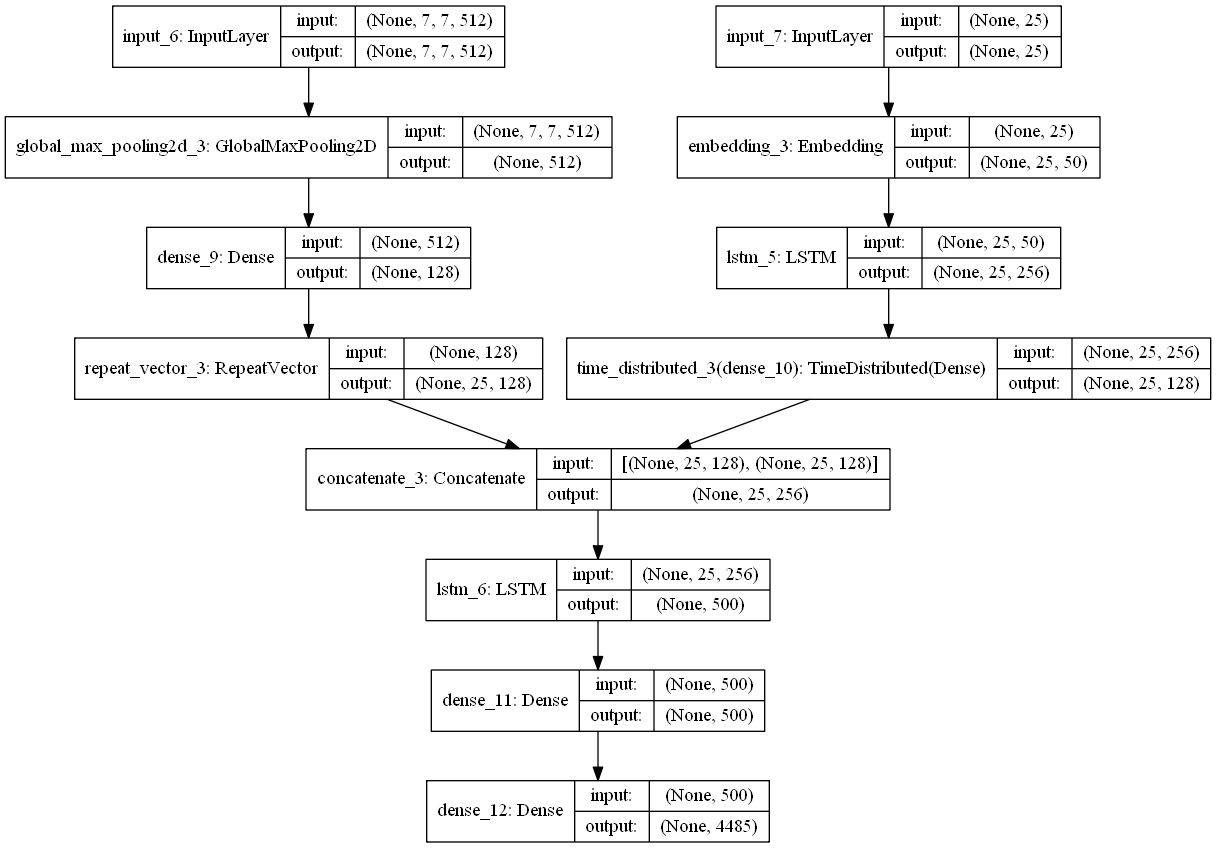

In [53]:
define_model(vocab_size, max_length)
Image('plot.png')

We will train the model using a data generator. This is strictly not required given that the captions and extracted photo features can probably fit into memory as a single dataset. Nevertheless, it is good practice for when you come to train the final model on the entire dataset.

A generator will yield a result when called. In Keras, it will yield a single batch of input-output samples that are used to estimate the error gradient and update the model weights.

The function `data_generator()` defines the data generator, given a dictionary of loaded photo descriptions, photo features, the tokenizer for integer encoding sequences, and the maximum sequence length in the dataset.

The generator loops forever and keeps yielding batches of input-output pairs when asked. We also have a `n_step` parameter that allows us to tune how many images worth of input-output pairs to generate for each batch. The average sequence has 10 words, that is 10 input-output pairs, and a good batch size might be 30 samples, which is about 2-to-3 images worth.

In [54]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length, n_step):
    # loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        keys = list(descriptions.keys())
        for i in range(0, len(keys), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(keys), i+n_step)):
                image_id = keys[j]
                # retrieve photo feature input
                image = features[image_id][0]
                # retrieve text input
                desc = descriptions[image_id]
                # generate input-output pairs
                in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]

The model can be fit by calling `fit_generator()` and passing it to the data generator, along with all of the parameters needed. When fitting the model, we can also specify the number of batches to run per epoch and the number of epochs.

`model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)`

For these experiments, we will use 2 images per batch, 50 batches (or 100 images) per epoch, and 50 training epochs. You can experiment with different configurations in your own experiments.

## Evaluate Model

Now that we know how to prepare the data and define a model, we must define a test harness to evaluate a given model.

We will evaluate a model by training it on the dataset, generating descriptions for all photos in the training dataset, evaluating those predictions with a cost function, and then repeating this evaluation process multiple times.

The outcome will be a distribution of skill scores for the model that we can summarize by calculating the mean and standard deviation. This is the preferred way to evaluate deep learning models. See this post:

* [How to Evaluate the Skill of Deep Learning Models](https://machinelearningmastery.com/evaluate-skill-deep-learning-models/)

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token *‘startseq‘*, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached *‘endseq‘* or the maximum description length is reached.

The function below named `generate_desc()` implements this behavior and generates a textual description given a trained model, and a given prepared photo as input. It calls the function `word_for_id()` in order to map an integer prediction back to a word.

In [55]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

We will generate predictions for all photos in the training dataset and in the test dataset.

The function below named `evaluate_model()` will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [56]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted)
    return bleu

BLEU scores are used in text translation for evaluating translated text against one or more reference translations. We do in fact have access to multiple reference descriptions for each image that we could compare to, but for simplicity, we will use the first description for each photo in the dataset (e.g. the cleaned version).

* [BLEU (bilingual evaluation understudy) on Wikipedia](https://en.wikipedia.org/wiki/BLEU)

The NLTK Python library implements the BLEU score calculation in the [*corpus_bleu() function*](http://www.nltk.org/api/nltk.translate.html). A higher score close to 1.0 is better, a score closer to zero is worse.

Finally, all we need to do is define, fit, and evaluate the model multiple times in a loop then report the final average score.

Ideally, we would repeat the experiment 30 times or more, but this will take too long for our small test harness. Instead, will evaluate the model 3 times. It will be faster, but the mean score will have higher variance.

Below defines the model evaluation loop. At the end of the run, the distribution of BLEU scores for the train and test sets are saved to a file.

In [ ]:
# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update),
                        steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>{}: train={} test={}'.format((i+1), train_score, test_score))
    
    
# save results to file
path = "D:/Program/dataset/Flickr8K/"
df = pd.DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(path+model_name+'.csv', index=False)

# Dataset copyright

Please cite M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results